# Orbitrap Data Analysis Code
#### Developer: ssz & tc; Last modified: March 27, 2021

In [2]:
#search for import above the current directory
import sys; sys.path.insert(0, '..')

In [4]:
import DataAnalyzerWithPeakInteg

In [5]:
import dataQualityPlots

### Analyze one specific raw file

Define the input file. Then define the list of peaks you extracted from FTStat in order. To do so, make a dictionary (here MetM1Dict) where keys are fragment names and values are lists, giving the peaks extracted for that fragment in order. The dictionary order should correspond to the FTStat order. 

e.g. if I extract the '133' fragment, peaks 'D' and '13C', and the '104' fragment, peaks '13C' and '15N', my dictionary is

{'133':['D','13C'],'104':['13C','15N']} and my FTStat file should have 133.D, 133.13C, 104.13C, 104.15N, in that order.

You also must specify a "most abundant" peak for each fragment, via the fragmentMostAbundant list. The program will compute the ratio of every isotope of that fragment with the "most abundant" peak. 

In [6]:
#Specific file name to look at
inputStandardFile = "Single_Fragment_Example_20201214_07_5 uL Methionine 5uM M+1 5e4 133.xlsx"
#outputPath = '20201214_07_5 uL Methionine 5uM M+1 5e4 133_outputtest.csv'

#This dictionary allows one to observe multiple fragments. Keys are fragment IDs and values are lists giving the
#substitutions observed for that fragment, in the order given in the FTStat file. The order for this dictionary
#should follow the FTStat file, i.e. the first key/value pair will correspond to the first n lines of the FTStat 
#file
MetM1Dict = {'133':['D','13C','33S','Unsub']}

#Choose the most abundant peak for each fragment. The order should be the same as the order of the key/value pairs
#in the above dictionary. This peak will be the denominator of the ratios for this fragment. 
fragmentMostAbundant = ['13C']

#Extract from dictionary. 
massStr = []
fragmentIsotopeList = []
for i, v in MetM1Dict.items():
    massStr.append(i)
    fragmentIsotopeList.append(v)
    
gc_elution_on = False
#peakTimeFrames = [(5.65,5.85), (6.82,7.62), (9.74,10.04), (10.00,10.30), (13.74,14.04)]

Import the data into a workable form (i.e., The FTStat import has each peak (single line of FTStat input code, i.e. a 13C or 15N peak) as a separate dataframe. This code combines these so that each fragment (where a fragment is a set of peaks, i.e. the 109 fragment as a 13C, 15N, and Unsubstituted peak) has a single dataframe. It then culls scans that fall outside of some threshold, i.e. here with TIC * IT more than three standard deviations from the mean. Note the isotopeList input is the same as defined in input 2; the same isotopeList is used in multiple functions and should be carried through the entire script, so it is easiest to change it once at the start.)

In [7]:
peaks = DataAnalyzerWithPeakInteg.import_Peaks_From_FTStatFile(inputStandardFile)
pandas = DataAnalyzerWithPeakInteg.convert_To_Pandas_DataFrame(peaks, None)
Merged = DataAnalyzerWithPeakInteg.combine_Substituted_Peaks(peakDF=pandas, cullOn = None, cullZeroScansOn = False, 
                                   gc_elution_on = gc_elution_on, gc_elution_times = None, 
                                   cullAmount = 2, fragmentIsotopeList = fragmentIsotopeList, NL_over_TIC = 0.10,
                                  debug = False)

Analyze data quality related to the AGC system, determining how TIC, IT, and TIC * IT vary with retention time and with each other. 

(Note: not sure how this applies to separate parts of the GC, especially once it is culled for each fragment). 

It also prints the standard deviation of each. A starting point is:
good <0.05-0.07
ok < 0.10
bad >0.10
But do not take this as absolute. 

**Notes:**
**You can change the df=Merged[x] line in order to look at the data quality of each fragment**

TIC Mean and STD
1.59e+07
0.05
IT Mean and STD
4.80e+00
0.05
TIC*IT Mean and STD
7.62e+04
0.07


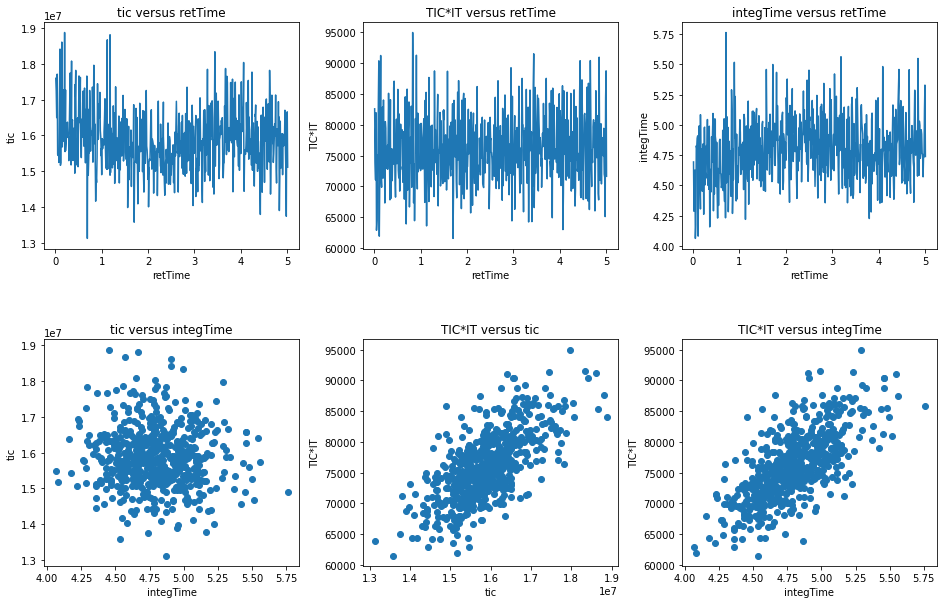

In [8]:
dataQualityPlots.ticPlot(Merged)

Observe peak drift as a first-order check on coalescence. This function computes the theoretical separation between isotopes, computes the actual separation, and plots the absolute value of their difference. As this difference gets larger, one should worry more about coalescence. A reasonable cut-off to be concerned is 0.0001 amu (but do NOT interpret this as a hard limit, as coalescence remains poorly understood). Consider also plotting how the ratio of a peak you are concerned about varies with AGC (eventually we hope to implement this automatically). 

134.0377310656304
134.03490508290156
134.03098605008637
133.0315661848014


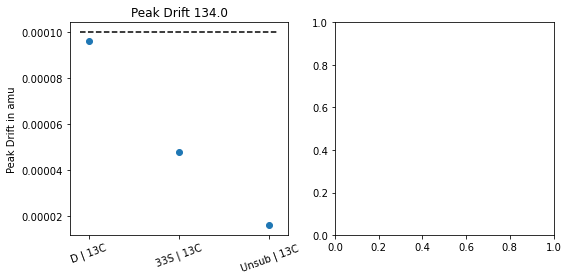

In [9]:
dataQualityPlots.peakDriftPlot(Merged, fragmentIsotopeList, fragmentMostAbundant, figsize = (8,4), printMasses = True)

Calculate and plot output for a single raw file. 
You may need to mess with the numCols, widthMultiple, and heightMultiple variables (increasing the latter two makes the figure wider or taller) to make the figure appear nice for different numbers of plots. 

In [12]:
outputList = DataAnalyzerWithPeakInteg.calc_Output_List(Merged, fragmentIsotopeList, fragmentMostAbundant, weightByNLHeight = False, debug = False)

Plots precision and RSE/SN ratio for each observed isotope ratio. 

In [ ]:
dataQualityPlots.plotOutputList(outputList, fragmentIsotopeList, fragmentMostAbundant, massStr, figsize = (10, 4))

Plots the counts per scan of each ion beam of each fragment. For each fragment, displays both counts with the y-axis scaled automatically and the y-axis scaled from 0-200. Set "CPmS = True" to calculate counts per millisecond rather than counts per scan, which may be useful to evaluate cleaning procedures. 

133
D Zero Counts: 0
13C Zero Counts: 0
33S Zero Counts: 0
Unsub Zero Counts: 0


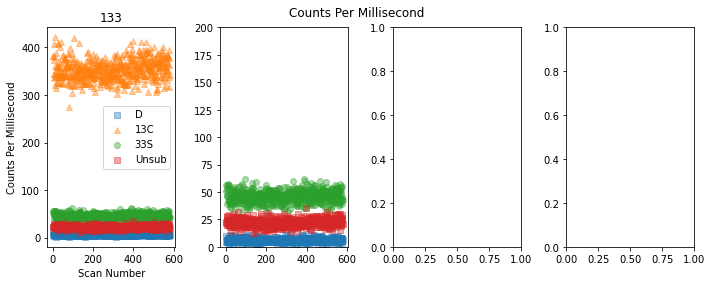

In [13]:
dataQualityPlots.countsPlot(Merged, fragmentIsotopeList, fragmentMostAbundant, massStr, figsize = (10,4), CPmS = True, 
           printZeros = True)

### An Example with Multiple Fragments

In [23]:
#Specific file name to look at
inputStandardFile = "Multiple_Fragment_Example_20201217_06_Methionine M3 Frag 250 uM 2e5 NCE 60.xlsx"
#outputPath = '20201214_07_5 uL Methionine 5uM M+1 5e4 133_outputtest.csv'

#This dictionary allows one to observe multiple fragments. Keys are fragment IDs and values are lists giving the
#substitutions observed for that fragment, in the order given in the FTStat file. The order for this dictionary
#should follow the FTStat file, i.e. the first key/value pair will correspond to the first n lines of the FTStat 
#file
MetM3Dict = {'133':['13C-18O','18O-33S','D-34S','13C-34S','34S'],
             '104':['D-34S','13C-34S','15N-34S','34S','13C','33S','Unsub'],
            '102':['13C-18O','18O','D','13C','15N','Unsub'],
             '88':['34S-D','13C-34S','34S','13C','33S','Unsub'],
             '74High':['13C-18O','18O','D','17O','13C','15N','Unsub'],
             '74Low':['13C-18O','18O','D','17O','13C','15N','Unsub'],
             '61':['D-34S','13C-34S','34S','13C','33S','Unsub'],
             '56':['D','13C','15N','Unsub']}

#Choose the most abundant peak for each fragment. The order should be the same as the order of the key/value pairs
#in the above dictionary. This peak will be the denominator of the ratios for this fragment. 
fragmentMostAbundant = ['13C-34S','13C-34S','13C','13C-34S','13C','Unsub','34S','13C']

#Extract from dictionary. 
massStr = []
fragmentIsotopeList = []
for i, v in MetM3Dict.items():
    massStr.append(i)
    fragmentIsotopeList.append(v)
    
gc_elution_on = False
#peakTimeFrames = [(5.65,5.85), (6.82,7.62), (9.74,10.04), (10.00,10.30), (13.74,14.04)]

In [24]:
peaks = DataAnalyzerWithPeakInteg.import_Peaks_From_FTStatFile(inputStandardFile)
pandas = DataAnalyzerWithPeakInteg.convert_To_Pandas_DataFrame(peaks, 0)
Merged = DataAnalyzerWithPeakInteg.combine_Substituted_Peaks(peakDF=pandas, cullOn = None, cullZeroScansOn = False, 
                                   gc_elution_on = gc_elution_on, gc_elution_times = None, 
                                   cullAmount = 2, fragmentIsotopeList = fragmentIsotopeList, NL_over_TIC = 0.10, 
                                   debug=False)

In [25]:
FI = [sub for fragment in fragmentIsotopeList for sub in fragment]

In [26]:
#A quick check--if you have defined the fragment dictionary properly, these should be the same length
#If they are not, a good approach is to run peakDriftPlot. Likely one of your fragments has one too many or 
#one too few peaks, and this will appear as a major drift, as the theoretical and observed fragment correspond
#to different things. 

#TODO: Implement this as an automatic check
print(len(FI))
print(len(pandas))

48
48


TIC Mean and STD
8.95e+06
0.05
IT Mean and STD
3.48e+01
0.05
TIC*IT Mean and STD
3.11e+05
0.06


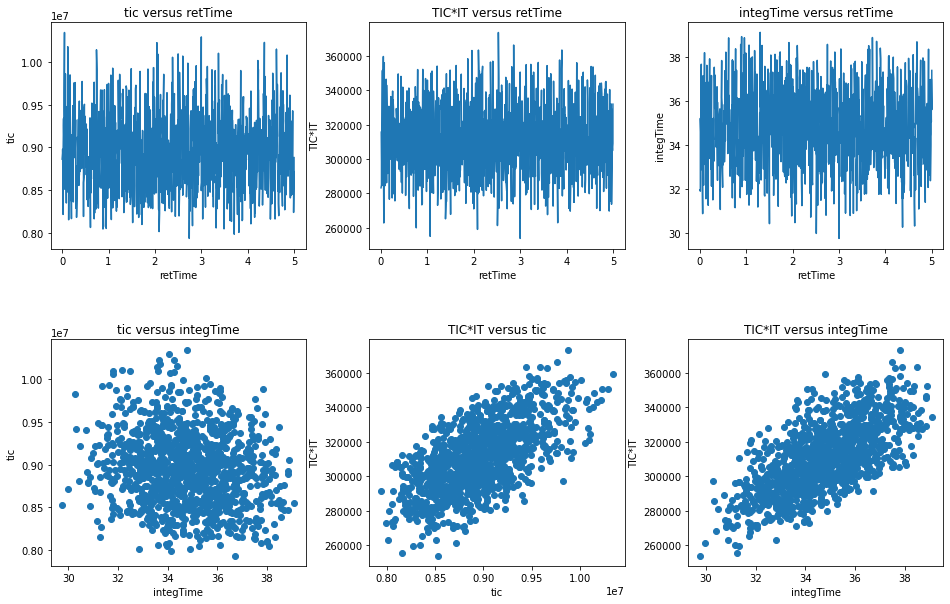

In [27]:
dataQualityPlots.ticPlot(Merged)

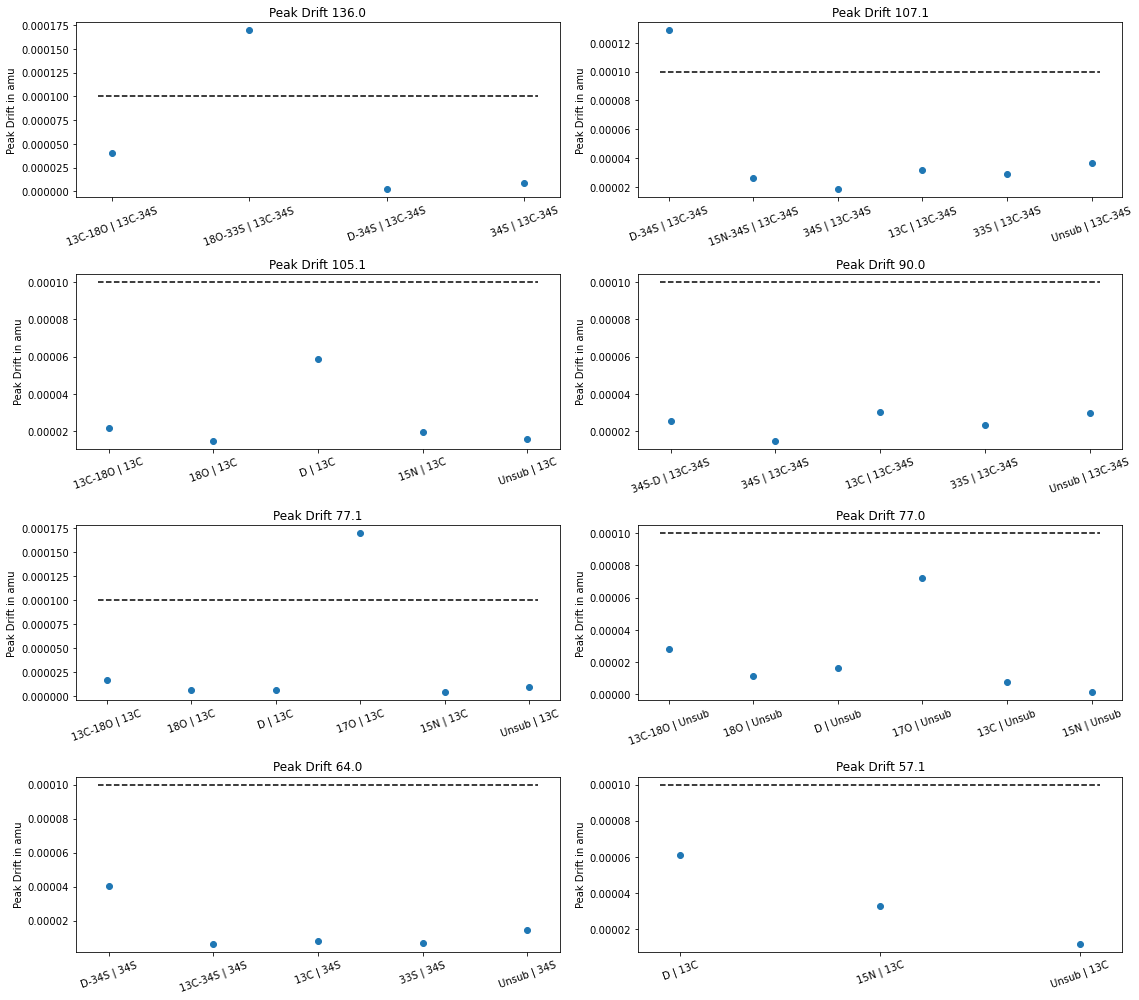

In [28]:
dataQualityPlots.peakDriftPlot(Merged, fragmentIsotopeList, fragmentMostAbundant, figsize = (16,14), printMasses = False)

In [29]:
outputList = DataAnalyzerWithPeakInteg.calc_Output_List(Merged, fragmentIsotopeList, fragmentMostAbundant, weightByNLHeight = False, debug = False)

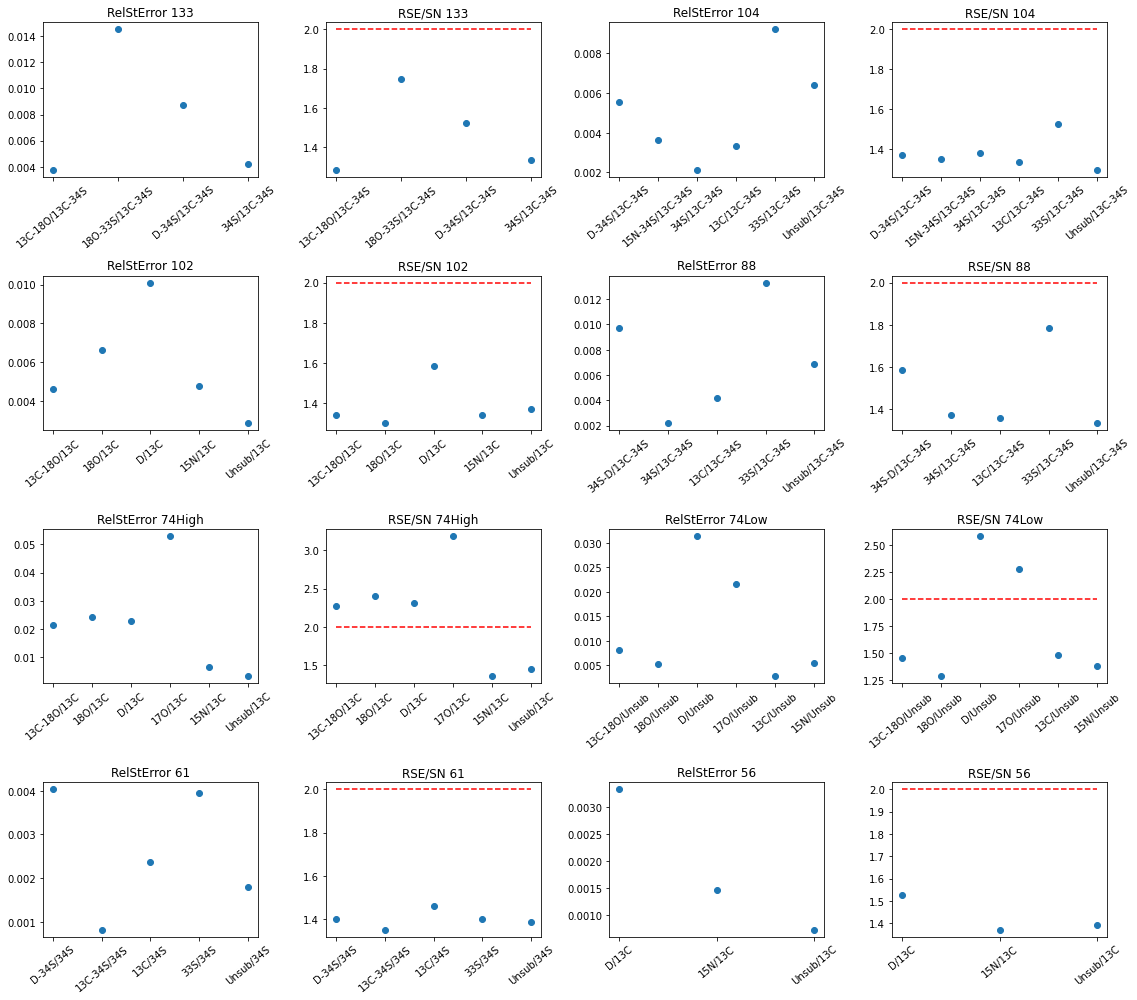

In [30]:
dataQualityPlots.plotOutputList(outputList, fragmentIsotopeList, fragmentMostAbundant, massStr, figsize = (16, 14))

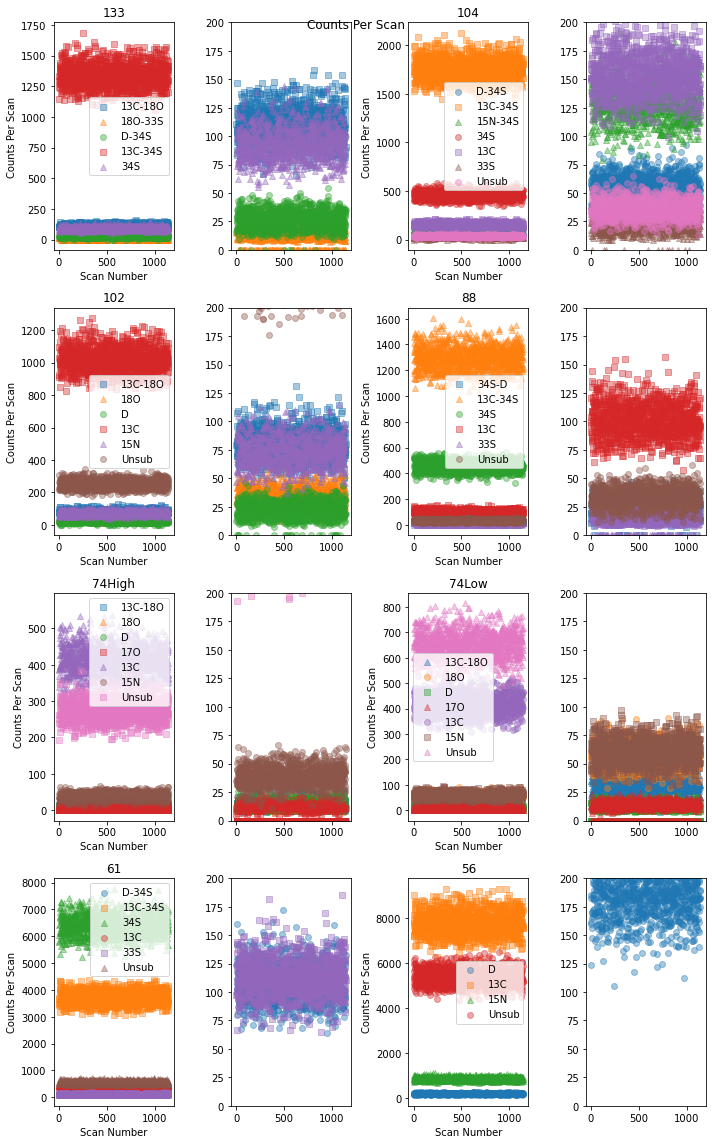

In [31]:
dataQualityPlots.countsPlot(Merged, fragmentIsotopeList, fragmentMostAbundant, massStr, figsize = (10,16), CPmS = False,
          printZeros = False)